#Mount Drive

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Libraries

In [88]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lit, year
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np

#Initialize Spark session

In [89]:
spark = SparkSession.builder.appName("IPL Score Prediction").getOrCreate()

#Load dataset

In [90]:
df = spark.read.csv("/content/ipl.csv", header=True, inferSchema=True)

#Exploring the dataset

Display dataset schema and first few rows

In [91]:
df.printSchema()
df.show(5)

root
 |-- mid: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- venue: string (nullable = true)
 |-- bat_team: string (nullable = true)
 |-- bowl_team: string (nullable = true)
 |-- batsman: string (nullable = true)
 |-- bowler: string (nullable = true)
 |-- runs: integer (nullable = true)
 |-- wickets: integer (nullable = true)
 |-- overs: double (nullable = true)
 |-- runs_last_5: integer (nullable = true)
 |-- wickets_last_5: integer (nullable = true)
 |-- striker: integer (nullable = true)
 |-- non-striker: integer (nullable = true)
 |-- total: integer (nullable = true)

+---+----------+--------------------+--------------------+--------------------+-----------+-------+----+-------+-----+-----------+--------------+-------+-----------+-----+
|mid|      date|               venue|            bat_team|           bowl_team|    batsman| bowler|runs|wickets|overs|runs_last_5|wickets_last_5|striker|non-striker|total|
+---+----------+--------------------+--------------------+

Summary statistics

In [92]:
df.describe().show()

+-------+------------------+----------------+-------------------+-------------------+--------------+--------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|summary|               mid|           venue|           bat_team|          bowl_team|       batsman|        bowler|             runs|           wickets|             overs|      runs_last_5|    wickets_last_5|           striker|       non-striker|            total|
+-------+------------------+----------------+-------------------+-------------------+--------------+--------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+
|  count|             76014|           76014|              76014|              76014|         76014|         76014|            76014|             76014|             76014|            76014|             760

Check for null values

In [93]:
from pyspark.sql.functions import isnan, when, count, col

numeric_cols = [c for c, dtype in df.dtypes if dtype in ('int', 'double')]

null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols])
null_counts.show()

+---+----+-------+-----+-----------+--------------+-------+-----------+-----+
|mid|runs|wickets|overs|runs_last_5|wickets_last_5|striker|non-striker|total|
+---+----+-------+-----+-----------+--------------+-------+-----------+-----+
|  0|   0|      0|    0|          0|             0|      0|          0|    0|
+---+----+-------+-----+-----------+--------------+-------+-----------+-----+



#Data Cleaning
• Removing unwanted columns • Keeping only consistent teams • Removing the first 5 overs data set in every match • Converting the column 'date' from string into datetime object

Drop rows with null values

In [94]:
df = df.dropna()

Remove duplicates

In [95]:
df = df.dropDuplicates()

Removing unwanted columns

In [96]:
columns_to_remove = ["mid", "venue", "batsman", "bowler", "striker", "non-striker"]
print(f"Before removing unwanted columns: {len(df.columns)} columns")
df = df.drop(*columns_to_remove)
print(f"After removing unwanted columns: {len(df.columns)} columns")

Before removing unwanted columns: 15 columns
After removing unwanted columns: 9 columns


Display remaining columns

In [97]:
print("Remaining columns:", df.columns)

Remaining columns: ['date', 'bat_team', 'bowl_team', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'total']


In [98]:
df.show(5)

+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+
|      date|            bat_team|           bowl_team|runs|wickets|overs|runs_last_5|wickets_last_5|total|
+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+
|2008-04-18|Kolkata Knight Ri...|Royal Challengers...|  22|      0|  2.3|         22|             0|  222|
|2008-04-18|Kolkata Knight Ri...|Royal Challengers...|  78|      1|  9.1|         24|             1|  222|
|2008-04-19|    Rajasthan Royals|    Delhi Daredevils|  59|      5| 10.6|         19|             3|  129|
|2008-04-22|     Deccan Chargers|    Delhi Daredevils|  34|      2|  6.6|         25|             1|  142|
|2008-04-23| Chennai Super Kings|      Mumbai Indians|  73|      2|  9.2|         34|             0|  208|
+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+
only showing top 5 rows



Adding Index

In [99]:
from pyspark.sql.functions import monotonically_increasing_id

df = df.withColumn("index", monotonically_increasing_id())

df.show(5)

+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+-----+
|      date|            bat_team|           bowl_team|runs|wickets|overs|runs_last_5|wickets_last_5|total|index|
+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+-----+
|2008-04-18|Kolkata Knight Ri...|Royal Challengers...|  22|      0|  2.3|         22|             0|  222|    0|
|2008-04-18|Kolkata Knight Ri...|Royal Challengers...|  78|      1|  9.1|         24|             1|  222|    1|
|2008-04-19|    Rajasthan Royals|    Delhi Daredevils|  59|      5| 10.6|         19|             3|  129|    2|
|2008-04-22|     Deccan Chargers|    Delhi Daredevils|  34|      2|  6.6|         25|             1|  142|    3|
|2008-04-23| Chennai Super Kings|      Mumbai Indians|  73|      2|  9.2|         34|             0|  208|    4|
+----------+--------------------+--------------------+----+-------+-----+-----------+-----------

Unique Team

In [100]:
df.select("bat_team").distinct().show()

+--------------------+
|            bat_team|
+--------------------+
| Sunrisers Hyderabad|
| Chennai Super Kings|
|     Deccan Chargers|
|Kochi Tuskers Kerala|
|    Rajasthan Royals|
|Royal Challengers...|
|Kolkata Knight Ri...|
|     Kings XI Punjab|
|       Pune Warriors|
|    Delhi Daredevils|
|      Mumbai Indians|
|Rising Pune Super...|
|       Gujarat Lions|
|Rising Pune Super...|
+--------------------+



Keeping only consistent teams

In [101]:
consistent_teams = ["Kolkata Knight Riders", "Chennai Super Kings", "Rajasthan Royals", "Mumbai Indians", "Kings XI Punjab", "Royal Challengers Bangalore", "Delhi Daredevils", "Sunrisers Hyderabad"]
print(f"Before removing inconsistent teams: {df.count()} rows")
df = df.filter((col("bat_team").isin(consistent_teams)) & (col("bowl_team").isin(consistent_teams)))
print(f"After removing inconsistent teams: {df.count()} rows")

Before removing inconsistent teams: 76014 rows
After removing inconsistent teams: 53811 rows


Unique team

In [102]:
df.select("bat_team").distinct().show()

+--------------------+
|            bat_team|
+--------------------+
| Sunrisers Hyderabad|
| Chennai Super Kings|
|    Rajasthan Royals|
|Royal Challengers...|
|Kolkata Knight Ri...|
|     Kings XI Punjab|
|    Delhi Daredevils|
|      Mumbai Indians|
+--------------------+



Removing the first 5 overs data in every match

In [103]:
print(f"Before removing first 5 overs data: {df.count()} rows")
df = df.filter(col("overs") >= 5.0)
print(f"After removing first 5 overs data: {df.count()} rows")

Before removing first 5 overs data: 53811 rows
After removing first 5 overs data: 40108 rows


Converting the 'date' column from string to datetime object

In [104]:
print(f"Before converting 'date' column from string to datetime: {df.schema['date'].dataType}")
df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
print(f"After converting 'date' column from string to datetime: {df.schema['date'].dataType}")

Before converting 'date' column from string to datetime: DateType()
After converting 'date' column from string to datetime: DateType()


#EDA
Heat Map

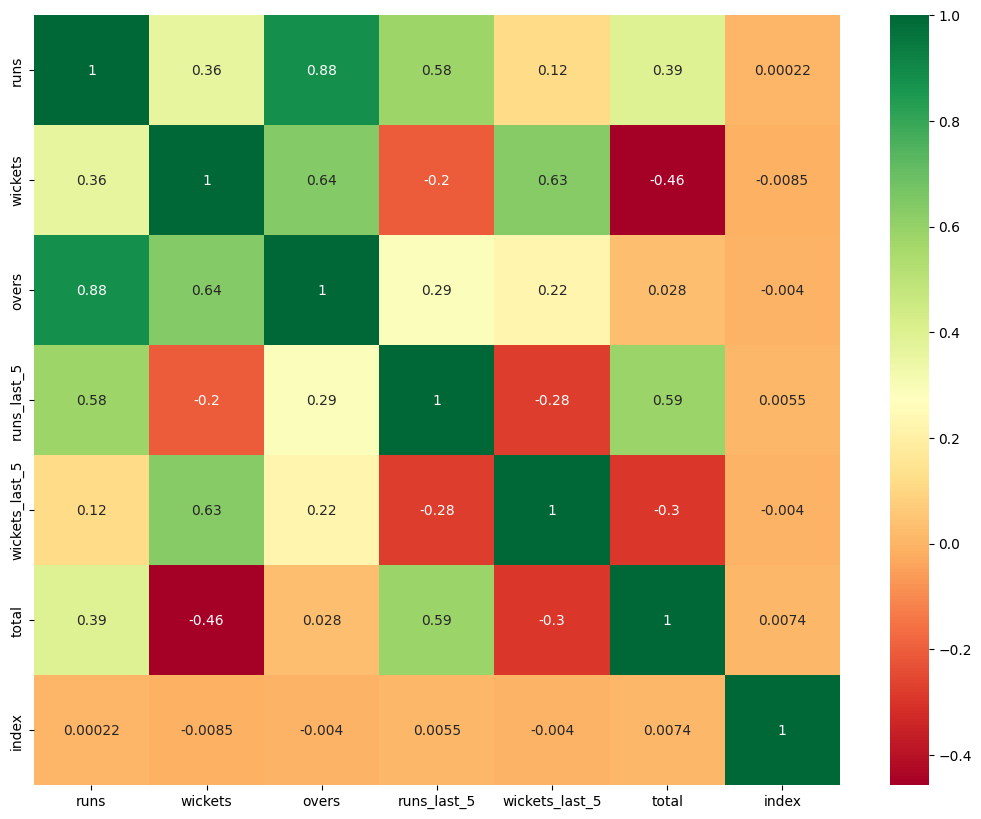

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_pd = df.toPandas()

numeric_cols = df_pd.select_dtypes(include=['number']).columns

corr_matrix = df_pd[numeric_cols].corr()

plt.figure(figsize=(13,10))
sns.heatmap(data=corr_matrix, annot=True, cmap='RdYlGn')
plt.show()

Pair Plot

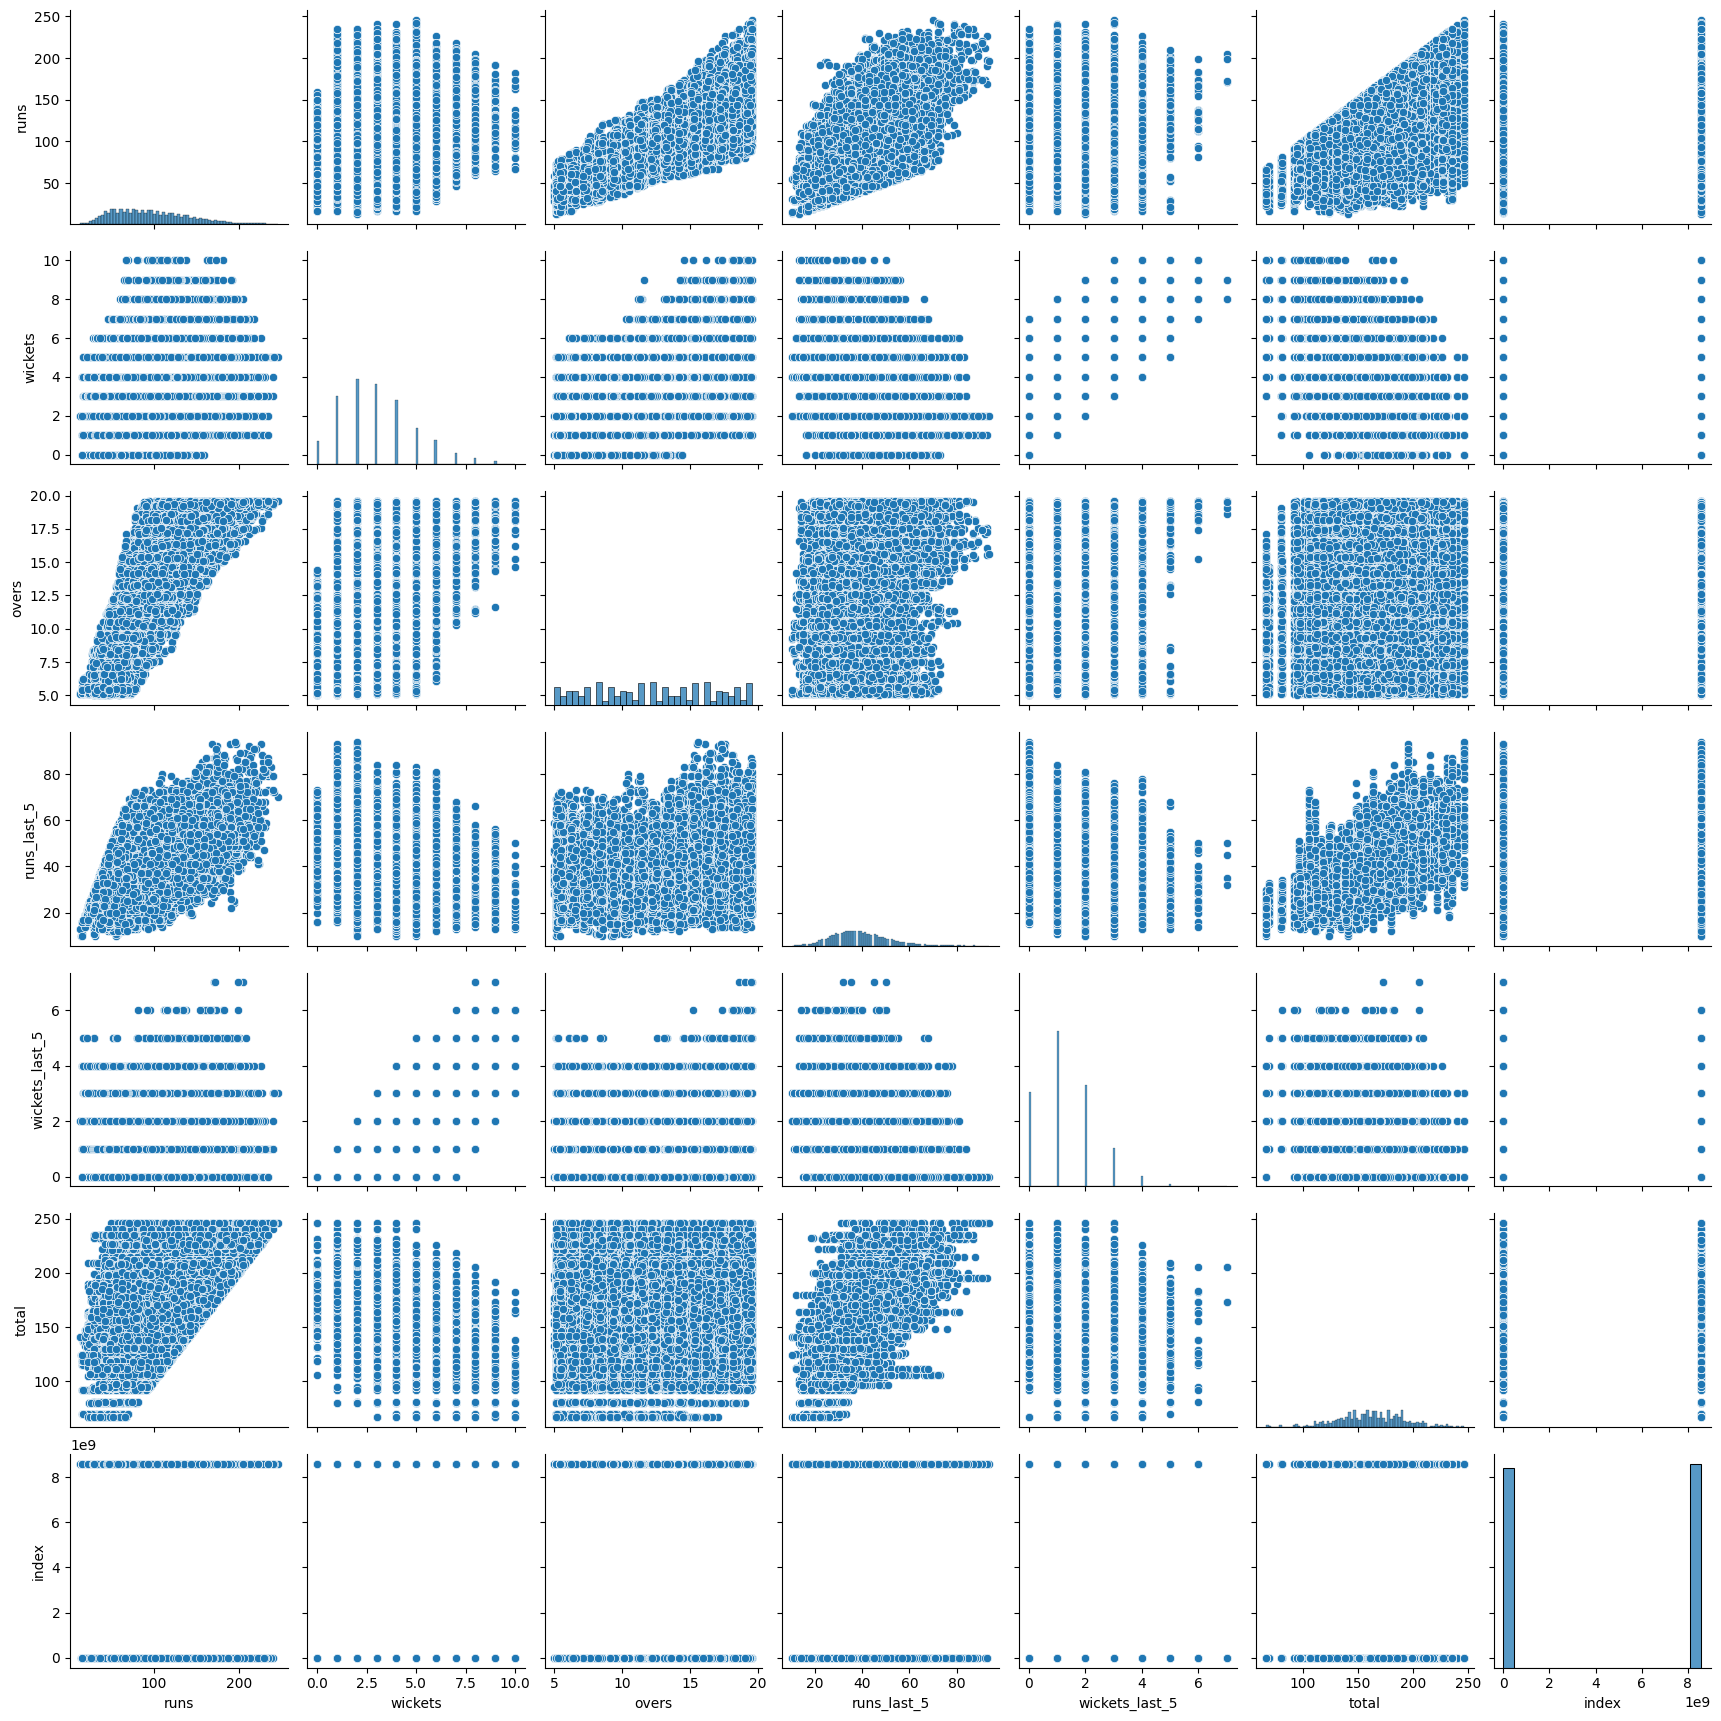

In [106]:
sns.pairplot(df_pd.select_dtypes(include=['number']))
plt.show()

Histogram Plot

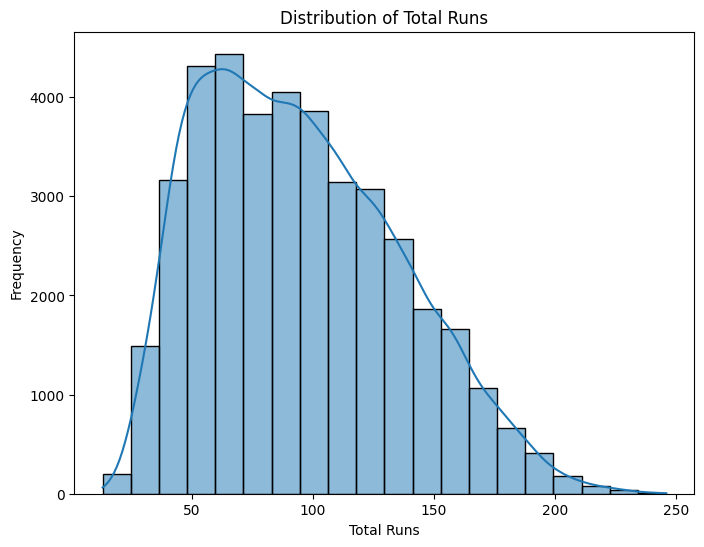

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

column_name = "total_runs"
if column_name not in df_pd.columns:
    column_name = "runs"

if column_name in df_pd.columns and pd.api.types.is_numeric_dtype(df_pd[column_name]):
    plt.figure(figsize=(8, 6))
    sns.histplot(df_pd[column_name], bins=20, kde=True)
    plt.title("Distribution of Total Runs")
    plt.xlabel("Total Runs")
    plt.ylabel("Frequency")
    plt.show()
else:
    print(f"Column '{column_name}' not found or not numeric. Available columns:", df_pd.columns)

Box Plot

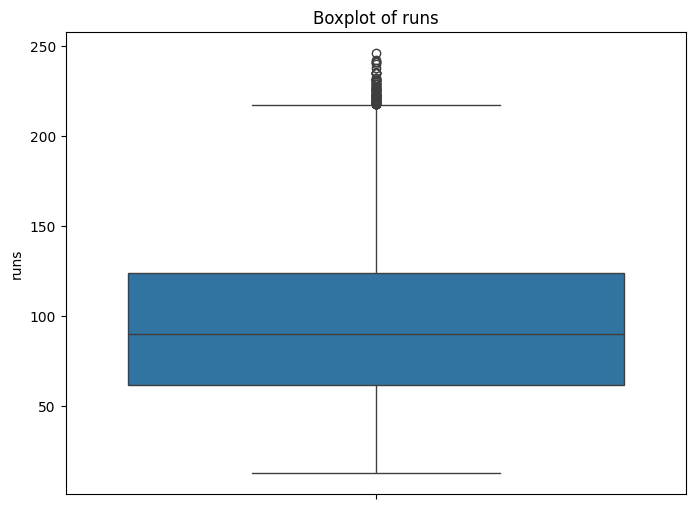

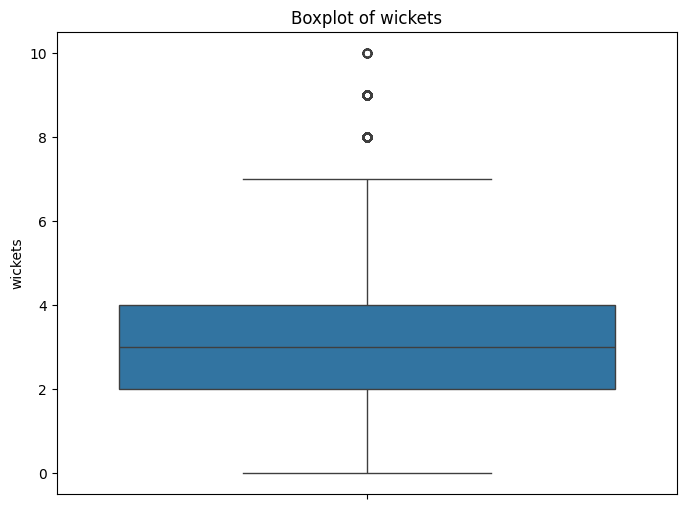

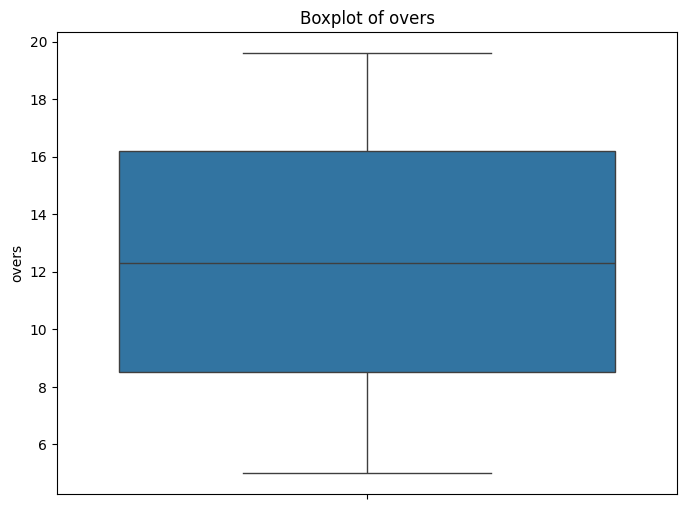

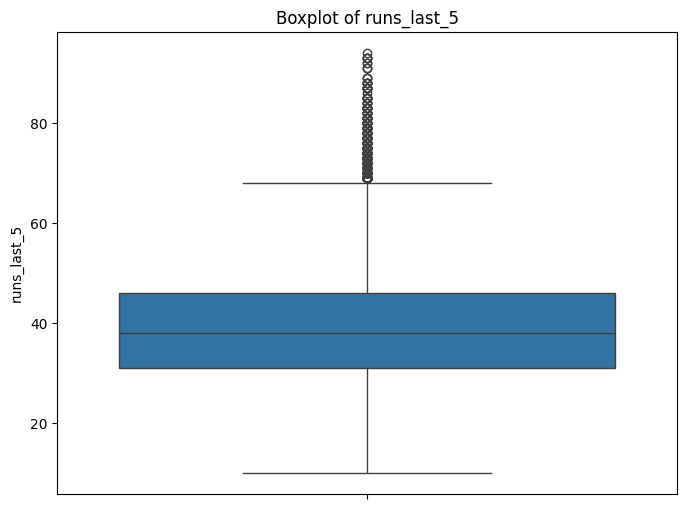

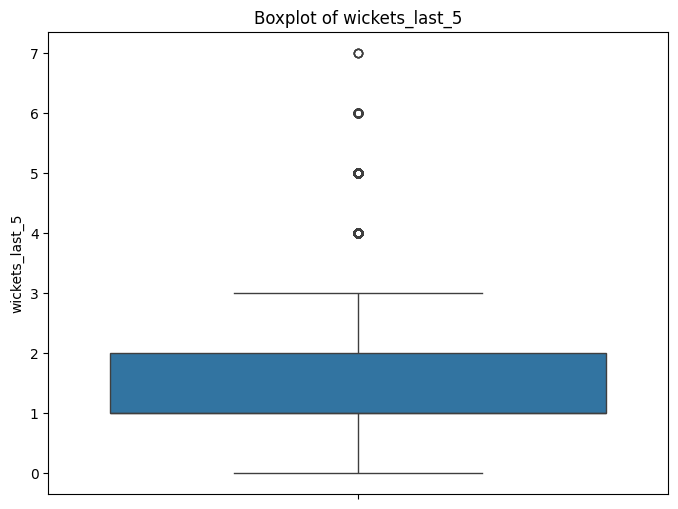

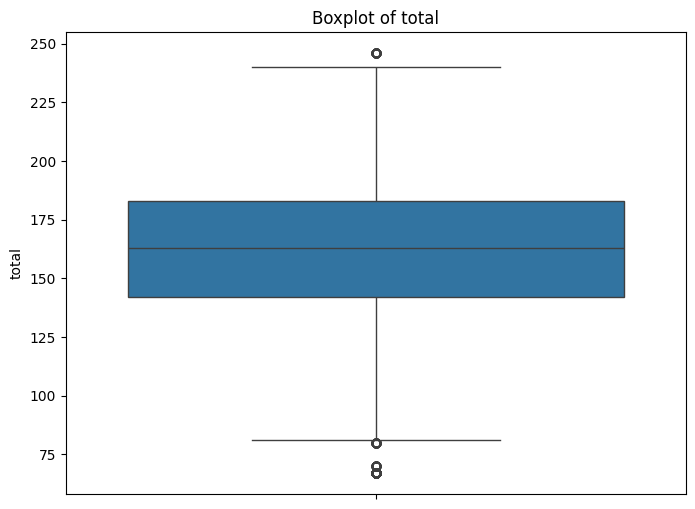

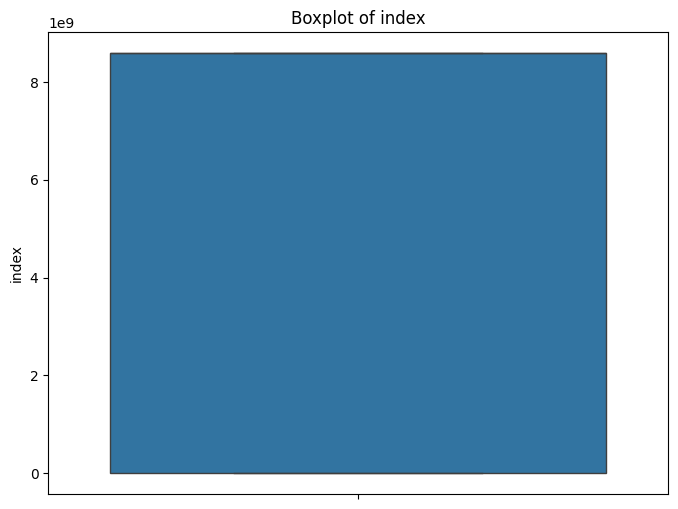

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_pd.select_dtypes(include=['number']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_pd[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

#Outliers

In [109]:
import numpy as np
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

In [110]:
from pyspark.sql.functions import col

def remove_outliers_iqr(df, columns):
    for column in columns:
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return df

# List of numerical columns
numeric_cols = ["runs", "overs", "runs_last_5", "wickets_last_5", "total"]

# Apply the function to remove outliers
df = remove_outliers_iqr(df, numeric_cols)

Box Plot

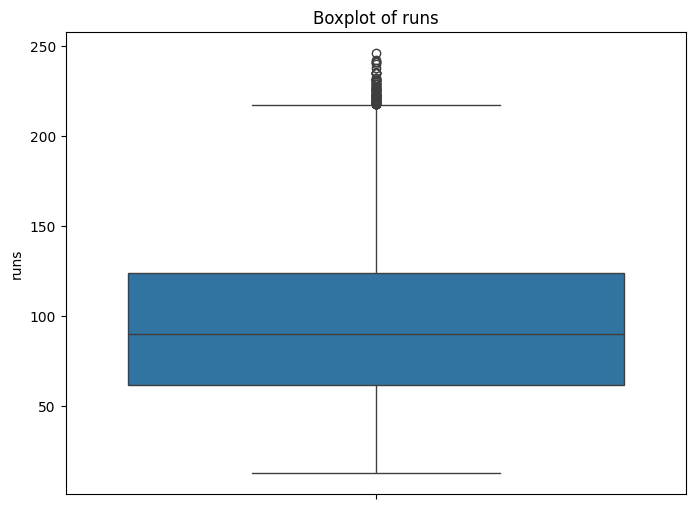

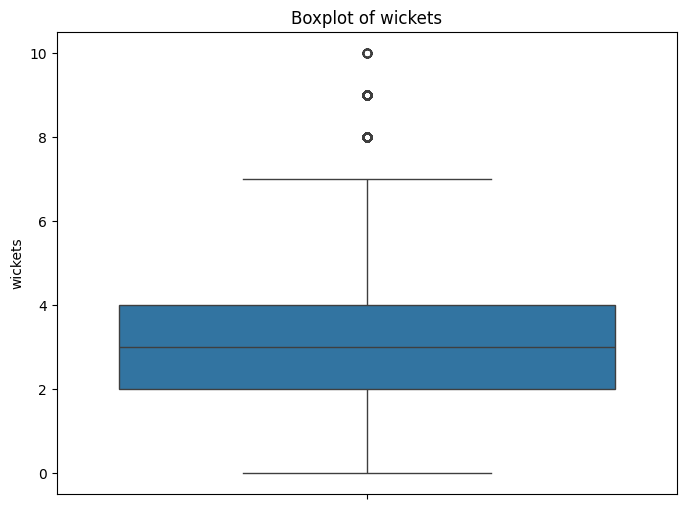

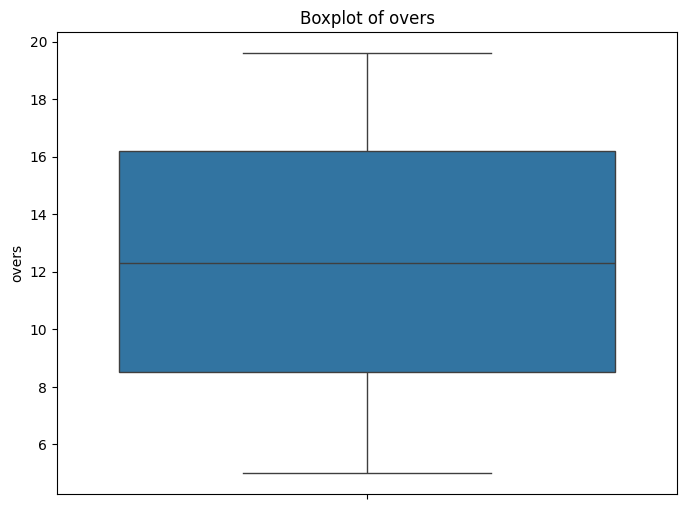

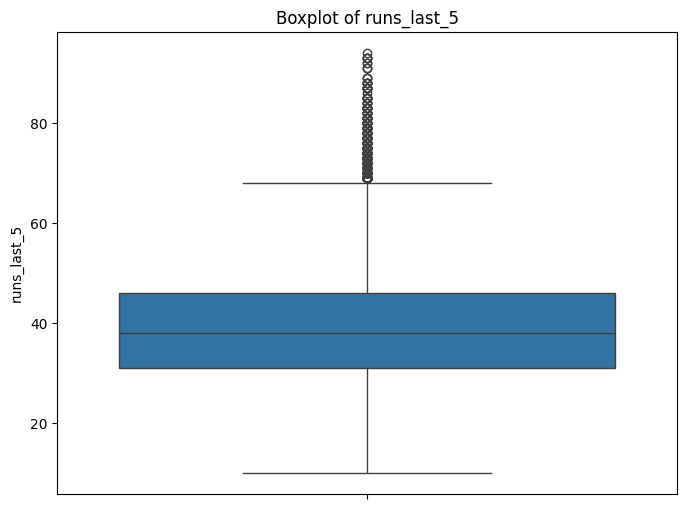

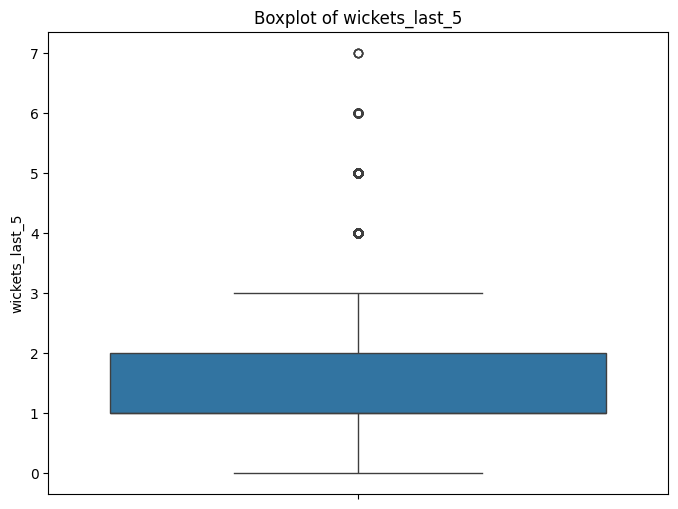

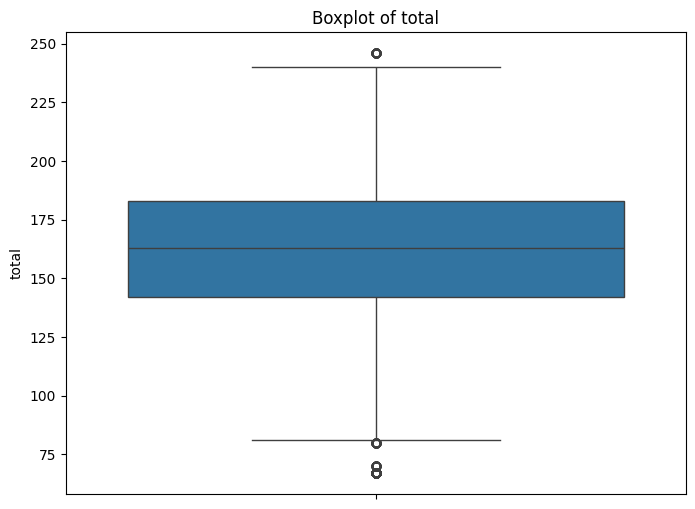

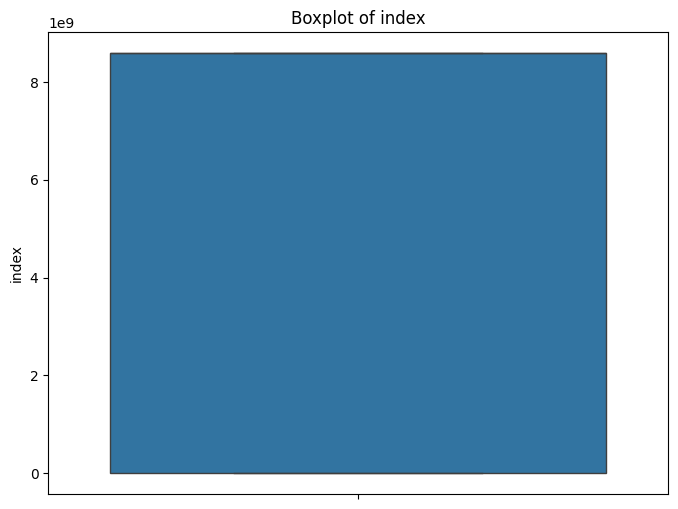

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_pd.select_dtypes(include=['number']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_pd[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

#Data Preprocessing
• Handling categorical features • Splitting dataset into train and test set on the basis of date

Converting categorical features using OneHotEncoding method

In [112]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col

bat_team_indexer = StringIndexer(inputCol="bat_team", outputCol="bat_team_index").fit(df)
bowl_team_indexer = StringIndexer(inputCol="bowl_team", outputCol="bowl_team_index").fit(df)

df = bat_team_indexer.transform(df)
df = bowl_team_indexer.transform(df)

bat_team_encoder = OneHotEncoder(inputCols=["bat_team_index"], outputCols=["bat_team_encoded"])
bowl_team_encoder = OneHotEncoder(inputCols=["bowl_team_index"], outputCols=["bowl_team_encoded"])

bat_team_model = bat_team_encoder.fit(df)
bowl_team_model = bowl_team_encoder.fit(df)

df = bat_team_model.transform(df)
df = bowl_team_model.transform(df)

print(df.columns)

['date', 'bat_team', 'bowl_team', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'total', 'index', 'bat_team_index', 'bowl_team_index', 'bat_team_encoded', 'bowl_team_encoded']


In [113]:
df.show(5)

+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+-----+--------------+---------------+----------------+-----------------+
|      date|            bat_team|           bowl_team|runs|wickets|overs|runs_last_5|wickets_last_5|total|index|bat_team_index|bowl_team_index|bat_team_encoded|bowl_team_encoded|
+----------+--------------------+--------------------+----+-------+-----+-----------+--------------+-----+-----+--------------+---------------+----------------+-----------------+
|2008-04-18|Kolkata Knight Ri...|Royal Challengers...|  78|      1|  9.1|         24|             1|  222|    1|           4.0|            2.0|   (7,[4],[1.0])|    (7,[2],[1.0])|
|2008-04-19|    Rajasthan Royals|    Delhi Daredevils|  59|      5| 10.6|         19|             3|  129|    2|           5.0|            0.0|   (7,[5],[1.0])|    (7,[0],[1.0])|
|2008-04-23| Chennai Super Kings|      Mumbai Indians|  73|      2|  9.2|         34|             0|  208

Rearranging the columns

In [114]:
selected_columns = [
    "date", "bat_team_encoded", "bowl_team_encoded",
    "overs", "runs", "wickets", "runs_last_5", "wickets_last_5", "total"
]

df = df.select([col(c) for c in selected_columns])

df.show(5)

+----------+----------------+-----------------+-----+----+-------+-----------+--------------+-----+
|      date|bat_team_encoded|bowl_team_encoded|overs|runs|wickets|runs_last_5|wickets_last_5|total|
+----------+----------------+-----------------+-----+----+-------+-----------+--------------+-----+
|2008-04-18|   (7,[4],[1.0])|    (7,[2],[1.0])|  9.1|  78|      1|         24|             1|  222|
|2008-04-19|   (7,[5],[1.0])|    (7,[0],[1.0])| 10.6|  59|      5|         19|             3|  129|
|2008-04-23|   (7,[2],[1.0])|    (7,[3],[1.0])|  9.2|  73|      2|         34|             0|  208|
|2008-04-26|   (7,[4],[1.0])|    (7,[6],[1.0])|  7.3|  64|      4|         32|             2|  147|
|2008-04-26|   (7,[4],[1.0])|    (7,[6],[1.0])| 19.6| 147|      9|         41|             3|  147|
+----------+----------------+-----------------+-----+----+-------+-----------+--------------+-----+
only showing top 5 rows



Splitting dataset into train and test set on the basis of date

In [115]:
train_df = df.filter(year(col("date")) <= 2016).drop("date")
test_df = df.filter(year(col("date")) >= 2017).drop("date")

print("Training set count: ", train_df.count())
print("Test set count: ", test_df.count())

Training set count:  34517
Test set count:  2515


#Model Building
I will experiment with 3 different algorithms, they are as follows: • Linear Regression • Decision Tree Regression • Random Forest Regression

----- Boosting Algorithm ----- • Adaptive Boosting (AdaBoost) Algorithm

#Linear Regression

In [116]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["bat_team_encoded", "bowl_team_encoded", "overs", "runs", "wickets", "runs_last_5", "wickets_last_5"],
    outputCol="features"
)

train_df = assembler.transform(train_df)

from pyspark.ml.regression import LinearRegression

linear_regressor = LinearRegression(featuresCol="features", labelCol="total")

linear_model = linear_regressor.fit(train_df)

print("Linear Regression Model trained successfully!")

Linear Regression Model trained successfully!


Predicting results

In [117]:
test_df = assembler.transform(test_df)

predictions_lr = linear_model.transform(test_df)

predictions_lr.select("prediction", "total").show(10)

+------------------+-----+
|        prediction|total|
+------------------+-----+
|155.79779278974127|  178|
|140.24083979939613|  148|
|158.54241734952421|  188|
| 162.0797614318909|  168|
|   163.05326043035|  168|
|149.75392330084918|  159|
| 155.5960226784345|  159|
|166.34735372515289|  131|
|160.34865764595153|  162|
| 177.4220697305898|  162|
+------------------+-----+
only showing top 10 rows



Linear Regression - Model Evaluation

In [118]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_mae = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="r2")

mae_lr = evaluator_mae.evaluate(predictions_lr)
mse_lr = evaluator_mse.evaluate(predictions_lr)
rmse_lr = evaluator_rmse.evaluate(predictions_lr)
r2_lr = evaluator_r2.evaluate(predictions_lr)

print("---- Linear Regression - Model Evaluation ----")
print(f"Mean Absolute Error (MAE): {mae_lr}")
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr}")
print(f"R-squared (R2): {r2_lr}")

---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 11.696447744463047
Mean Squared Error (MSE): 219.2925768220257
Root Mean Squared Error (RMSE): 14.808530542293036
R-squared (R2): 0.6760237874575787


#Decision Tree Regressor model

In [119]:
from pyspark.ml.regression import DecisionTreeRegressor

decision_regressor = DecisionTreeRegressor(featuresCol="features", labelCol="total")

decision_tree_model = decision_regressor.fit(train_df)

print("Decision Tree Regression Model trained successfully!")

Decision Tree Regression Model trained successfully!


Predicting results

In [120]:
predictions_dt = decision_tree_model.transform(test_df)

predictions_dt.select("prediction", "total").show(10)

+------------------+-----+
|        prediction|total|
+------------------+-----+
| 147.3019943019943|  178|
|132.04761904761904|  148|
|147.03508771929825|  188|
|158.41580547112463|  168|
|158.41580547112463|  168|
|163.65428824049513|  159|
| 163.5582573454914|  159|
| 147.3019943019943|  131|
|131.75757575757575|  162|
| 163.5582573454914|  162|
+------------------+-----+
only showing top 10 rows



Decision Tree Regression - Model Evaluation

In [121]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_mae = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="r2")

mae_dt = evaluator_mae.evaluate(predictions_dt)
mse_dt = evaluator_mse.evaluate(predictions_dt)
rmse_dt = evaluator_rmse.evaluate(predictions_dt)
r2_dt = evaluator_r2.evaluate(predictions_dt)

print("---- Decision Tree Regression - Model Evaluation ----")
print(f"Mean Absolute Error (MAE): {mae_dt}")
print(f"Mean Squared Error (MSE): {mse_dt}")
print(f"Root Mean Squared Error (RMSE): {rmse_dt}")
print(f"R-squared (R2): {r2_dt}")

---- Decision Tree Regression - Model Evaluation ----
Mean Absolute Error (MAE): 16.013703342723673
Mean Squared Error (MSE): 386.37810216093027
Root Mean Squared Error (RMSE): 19.656502795790768
R-squared (R2): 0.4291766918812815


#Random Forest Regressor model

In [122]:
from pyspark.ml.regression import RandomForestRegressor

random_regressor = RandomForestRegressor(featuresCol="features", labelCol="total", numTrees=100)

random_forest_model = random_regressor.fit(train_df)

print("Random Forest Regression Model trained successfully!")

Random Forest Regression Model trained successfully!


Predicting results

In [123]:
predictions_rf = random_forest_model.transform(test_df)

predictions_rf.select("prediction", "total").show(10)

+------------------+-----+
|        prediction|total|
+------------------+-----+
| 146.6618464473995|  178|
|142.54434011564584|  148|
| 154.0680020932572|  188|
|153.41433392800903|  168|
|153.58089556484478|  168|
|159.43694705808682|  159|
|162.18211319467008|  159|
|150.97283455773876|  131|
|146.71106996435844|  162|
| 167.3560585388568|  162|
+------------------+-----+
only showing top 10 rows



Random Forest Regression - Model Evaluation

In [124]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_mae = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="r2")

mae_rf = evaluator_mae.evaluate(predictions_rf)
mse_rf = evaluator_mse.evaluate(predictions_rf)
rmse_rf = evaluator_rmse.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print("---- Random Forest Regression - Model Evaluation ----")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R2): {r2_rf}")

---- Random Forest Regression - Model Evaluation ----
Mean Absolute Error (MAE): 15.120995787158224
Mean Squared Error (MSE): 360.48465880802326
Root Mean Squared Error (RMSE): 18.986433546298876
R-squared (R2): 0.46743088100490515


Note: Since Linear Regression model performs best as compared to other two, we use this model and boost it's performance using AdaBoost Algorithm

#AdaBoost Algorithm

In [125]:
from pyspark.ml.regression import GBTRegressor

gbt_regressor = GBTRegressor(featuresCol="features", labelCol="total", maxIter=100)

gbt_model = gbt_regressor.fit(train_df)

print("Gradient Boosted Tree (AdaBoost Alternative) Model trained successfully!")

Gradient Boosted Tree (AdaBoost Alternative) Model trained successfully!


Predicting results

In [126]:
predictions_gbt = gbt_model.transform(test_df)

predictions_gbt.select("prediction", "total").show(10)

+------------------+-----+
|        prediction|total|
+------------------+-----+
|155.70336437747684|  178|
|133.11896265557442|  148|
|154.60430183606238|  188|
|160.70064235025797|  168|
|160.63700118728104|  168|
| 164.4942388601812|  159|
|159.00328505262516|  159|
|165.23245585548443|  131|
|166.98564672723919|  162|
| 163.0317715062765|  162|
+------------------+-----+
only showing top 10 rows



AdaBoost Regression - Model Evaluation

In [127]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_mae = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="mse")
evaluator_rmse = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="total", predictionCol="prediction", metricName="r2")

mae_gbt = evaluator_mae.evaluate(predictions_gbt)
mse_gbt = evaluator_mse.evaluate(predictions_gbt)
rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)

print("---- Gradient Boosted Trees (AdaBoost Alternative) - Model Evaluation ----")
print(f"Mean Absolute Error (MAE): {mae_gbt}")
print(f"Mean Squared Error (MSE): {mse_gbt}")
print(f"Root Mean Squared Error (RMSE): {rmse_gbt}")
print(f"R-squared (R2): {r2_gbt}")

---- Gradient Boosted Trees (AdaBoost Alternative) - Model Evaluation ----
Mean Absolute Error (MAE): 13.724359461350554
Mean Squared Error (MSE): 287.14966867596564
Root Mean Squared Error (RMSE): 16.945491101646056
R-squared (R2): 0.5757737747504701


Note: Using AdaBoost did not reduce the error to a significant level. Hence, we will use simple linear regression model for prediction

#Prediction
• Model trained on the data from IPL Seasons 1 to 9 ie: (2008 to 2016) • Model tested on data from IPL Season 10 ie: (2017) • Model predicts on data from IPL Seasons 11 to 12 ie: (2018 to 2019)

In [128]:
def predict_score(batting_team='Chennai Super Kings', bowling_team='Mumbai Indians', overs=5.1, runs=50, wickets=0, runs_in_prev_5=50, wickets_in_prev_5=0):
  temp_array = list()


  if batting_team == 'Chennai Super Kings':
    temp_array = temp_array + [1,0,0,0,0,0,0,0]
  elif batting_team == 'Delhi Daredevils':
    temp_array = temp_array + [0,1,0,0,0,0,0,0]
  elif batting_team == 'Kings XI Punjab':
    temp_array = temp_array + [0,0,1,0,0,0,0,0]
  elif batting_team == 'Kolkata Knight Riders':
    temp_array = temp_array + [0,0,0,1,0,0,0,0]
  elif batting_team == 'Mumbai Indians':
    temp_array = temp_array + [0,0,0,0,1,0,0,0]
  elif batting_team == 'Rajasthan Royals':
    temp_array = temp_array + [0,0,0,0,0,1,0,0]
  elif batting_team == 'Royal Challengers Bangalore':
    temp_array = temp_array + [0,0,0,0,0,0,1,0]
  elif batting_team == 'Sunrisers Hyderabad':
    temp_array = temp_array + [0,0,0,0,0,0,0,1]

  # Bowling Team
  if bowling_team == 'Chennai Super Kings':
    temp_array = temp_array + [1,0,0,0,0,0,0,0]
  elif bowling_team == 'Delhi Daredevils':
    temp_array = temp_array + [0,1,0,0,0,0,0,0]
  elif bowling_team == 'Kings XI Punjab':
    temp_array = temp_array + [0,0,1,0,0,0,0,0]
  elif bowling_team == 'Kolkata Knight Riders':
    temp_array = temp_array + [0,0,0,1,0,0,0,0]
  elif bowling_team == 'Mumbai Indians':
    temp_array = temp_array + [0,0,0,0,1,0,0,0]
  elif bowling_team == 'Rajasthan Royals':
    temp_array = temp_array + [0,0,0,0,0,1,0,0]
  elif bowling_team == 'Royal Challengers Bangalore':
    temp_array = temp_array + [0,0,0,0,0,0,1,0]
  elif bowling_team == 'Sunrisers Hyderabad':
    temp_array = temp_array + [0,0,0,0,0,0,0,1]

  # Overs, Runs, Wickets, Runs_in_prev_5, Wickets_in_prev_5
  temp_array = temp_array + [overs, runs, wickets, runs_in_prev_5, wickets_in_prev_5]

  # Converting into numpy array
  temp_array = np.array([temp_array])

  # Prediction
  return int(linear_regressor.predict(temp_array)[0])


In [129]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler

def predict_score(batting_team='Chennai Super Kings', bowling_team='Mumbai Indians', overs=5.1, runs=50, wickets=0, runs_in_prev_5=50, wickets_in_prev_5=0):

    spark = SparkSession.builder.appName("IPL Score Prediction").getOrCreate()


    input_data = {
        "bat_team": batting_team,
        "bowl_team": bowling_team,
        "overs": overs,
        "runs": runs,
        "wickets": wickets,
        "runs_last_5": runs_in_prev_5,
        "wickets_last_5": wickets_in_prev_5
    }

    input_df = spark.createDataFrame([Row(**input_data)])


    input_df = bat_team_indexer.transform(input_df)
    input_df = bowl_team_indexer.transform(input_df)
    input_df = bat_team_encoder.transform(input_df)
    input_df = bowl_team_encoder.transform(input_df)


    input_df = assembler.transform(input_df)

    predictions = linear_model.transform(input_df)


    predicted_score = predictions.select("prediction").collect()[0][0]

    return int(predicted_score)

In [130]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

def predict_score(batting_team='Chennai Super Kings', bowling_team='Mumbai Indians', overs=5.1, runs=50, wickets=0, runs_in_prev_5=50, wickets_in_prev_5=0):

    spark = SparkSession.builder.appName("IPL Score Prediction").getOrCreate()


    input_data = {
        "bat_team": batting_team,
        "bowl_team": bowling_team,
        "overs": overs,
        "runs": runs,
        "wickets": wickets,
        "runs_last_5": runs_in_prev_5,
        "wickets_last_5": wickets_in_prev_5
    }


    input_df = spark.createDataFrame([Row(**input_data)])


    input_df = bat_team_indexer.transform(input_df)
    input_df = bowl_team_indexer.transform(input_df)


    input_df = bat_team_encoder.transform(input_df)
    input_df = bowl_team_encoder.transform(input_df)

    input_df = assembler.transform(input_df)


    predictions = linear_model.transform(input_df)


    predicted_score = predictions.select("prediction").collect()[0][0]

    return int(predicted_score)

In [131]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

def predict_score(batting_team='Chennai Super Kings', bowling_team='Mumbai Indians', overs=5.1, runs=50, wickets=0, runs_in_prev_5=50, wickets_in_prev_5=0):

    spark = SparkSession.builder.appName("IPL Score Prediction").getOrCreate()

    input_data = {
        "bat_team": batting_team,
        "bowl_team": bowling_team,
        "overs": overs,
        "runs": runs,
        "wickets": wickets,
        "runs_last_5": runs_in_prev_5,
        "wickets_last_5": wickets_in_prev_5
    }

    input_df = spark.createDataFrame([Row(**input_data)])

    input_df = bat_team_indexer.transform(input_df)
    input_df = bowl_team_indexer.transform(input_df)

    input_df = bat_team_model.transform(input_df)
    input_df = bowl_team_model.transform(input_df)

    input_df = assembler.transform(input_df)

    predictions = linear_model.transform(input_df)

    predicted_score = predictions.select("prediction").collect()[0][0]

    return int(predicted_score)

In [132]:
predicted_score = predict_score(
    batting_team='Chennai Super Kings',
    bowling_team='Mumbai Indians',
    overs=10,
    runs=80,
    wickets=2,
    runs_in_prev_5=40,
    wickets_in_prev_5=1
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 167


#Prediction 1
• Date: 14th April 2019
• IPL : Season 12
• Match number: 30
• Teams: Sunrisers Hyderabad vs. Delhi Daredevils
• First Innings final score: 155/7

In [133]:
predicted_score = predict_score(
    batting_team='Delhi Daredevils',
    bowling_team='Sunrisers Hyderabad',
    overs=11.5,
    runs=98,
    wickets=3,
    runs_in_prev_5=41,
    wickets_in_prev_5=1
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 170


#Prediction 2
• Date: 10th May 2019 • IPL : Season 12 • Match number: 59 (Eliminator) • Teams: Delhi Daredevils vs. Chennai Super Kings • First Innings final score: 147/9

In [134]:
predicted_score = predict_score(
    batting_team='Delhi Daredevils',
    bowling_team='Chennai Super Kings',
    overs=10.2,
    runs=68,
    wickets=3,
    runs_in_prev_5=29,
    wickets_in_prev_5=1
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 148


#Prediction 3
• Date: 11th April 2019 • IPL : Season 12 • Match number: 25 • Teams: Rajasthan Royals vs. Chennai Super Kings • First Innings final score: 151/7

In [135]:
predicted_score = predict_score(
    batting_team='Rajasthan Royals',
    bowling_team='Chennai Super Kings',
    overs=13.3,
    runs=92,
    wickets=5,
    runs_in_prev_5=27,
    wickets_in_prev_5=2
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 138



#Prediction 4
• Date: 30th March 2019 • IPL : Season 12 • Match number: 9 • Teams: Mumbai Indians vs. Kings XI Punjab • First Innings final score: 176/7

In [136]:
predicted_score = predict_score(
    batting_team='Mumbai Indians',
    bowling_team='Kings XI Punjab',
    overs=12.3,
    runs=113,
    wickets=2,
    runs_in_prev_5=55,
    wickets_in_prev_5=0
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 188


#Prediction 5
• Date: 17th May 2018 • IPL : Season 11 • Match number: 50 • Teams: Mumbai Indians vs. Kings XI Punjab • First Innings final score: 186/8

In [137]:
predicted_score = predict_score(
    batting_team='Mumbai Indians',
    bowling_team='Kings XI Punjab',
    overs=14.1,
    runs=136,
    wickets=4,
    runs_in_prev_5=50,
    wickets_in_prev_5=0
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 189


#Prediction 6
• Date: 16th April 2018 • IPL : Season 11 • Match number: 13 • Teams: Kolkata Knight Riders vs. Delhi Daredevils • First Innings final score: 200/9

In [138]:
predicted_score = predict_score(
    batting_team='Kolkata Knight Riders',
    bowling_team='Delhi Daredevils',
    overs=9.2,
    runs=79,
    wickets=2,
    runs_in_prev_5=60,
    wickets_in_prev_5=1
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 170


#Prediction 7
• Date: 7th May 2018
• IPL : Season 11
• Match number: 39
• Teams: Sunrisers Hyderabad vs. Royal Challengers Bangalore
• First Innings final score: 146/10

In [139]:
predicted_score = predict_score(
    batting_team='Sunrisers Hyderabad',
    bowling_team='Royal Challengers Bangalore',
    overs=10.5,
    runs=67,
    wickets=3,
    runs_in_prev_5=29,
    wickets_in_prev_5=1
)
print(f"Predicted Score: {predicted_score}")

Predicted Score: 148


#Deployment
Pickle File

In [140]:
import pickle

model_data = {
    "coefficients": linear_model.coefficients,
    "intercept": linear_model.intercept
}

pickle_path = "/content/drive/My Drive/IPL/linear_model.pkl"

with open(pickle_path, "wb") as f:
    pickle.dump(model_data, f)

print("Model saved successfully as a pickle file!")

Model saved successfully as a pickle file!


In [141]:
import pickle
from pyspark.ml.regression import LinearRegressionModel

model_path = "linear_model"

linear_model.write().overwrite().save(model_path)

with open("linear_model_metadata.pkl", "wb") as file:
    pickle.dump({"model_path": model_path}, file)